# Stats Project 5

## Counting and the Poisson Distribution

You will no doubt recall the examples we worked out involving defect rates on an assembly line. We assumed an average time between defects of 10 minutes (or equivalently: 6 defects/hour). However the time between defects was a random variable and I claimed that this population of random time intervals would be exponentially distributed. This week we'll explore this claim a bit more deeply and also learn about an extremely practical tool for analysing situtions in which events occur with a well defined rate: [The Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution).

## Coin Flipping Again

First however, we need to go back to coin flipping for a second. There is a connection between coin flipping and the Poisson distribution that I'd like to describe so you can see the logical connection for this to make sense. Suppose I flip a coin 10 times. What's the chance of seeing a particular set of heads and tails?

    HHTHTTHTTT

Because there are 10 flips, and each flip has two possible outcomes, there are $2^{10}$ or 1024 possible outcomes. This particular outcome is just one of 1024 so the chance of seeing this exact outcome is 1.0/1024 or approximately one in a thousand or so. However, we could ask a *different* question: What's the chance of seeing an outcome *like* this, with the same number of heads (4) and the same number of tails (6) without regard to which exact flips were heads and tails? This is a more subtle question! 

The key concept here is the combinitorial counting strategy of tracking how many ways can you arrange N distinct things. The answer is $N!$. Why? Assume you have $N$ 'slots'. Into these slots you can place N things, but only *one* thing can go in each slot, so that at the end you'll have an ordered arrangement of N objects. There are $N$ ways to place the first object, $N-1$ ways for the second and so on. How many ways are there to place all $N$? 

$$ {\rm Ways} = N\times(N-1)\times(N-2)\times\cdots\times1$$

So this is nothing other than $N!$.

So! There 10! ways place 10 objects. How does that help with the coin question? It helps because there are 10! ways to arrange the 10 coins, but we can rearrange the heads and tails without affecting the answer so we need to *divide* by the number of ways to arrange the heads (4!), and the number ways to arrange the tails (6!) to get:

$$ {\rm Ways} = \frac{10!}{4! 6!} = \frac{10\times9\times8\times7}{4\times3\times2} $$

$$ {\rm Ways} = 5\times3\times2\times7 = 15\times14 = 210 $$

So, there are 210 ways of getting 4 heads and 6 tails when flipping a coin 10 times. Now what's the chance of that? That depends on the probability of flipping a "heads" or a "tails". Assuming a fair coin, these are both 50%. Since I flip the coins 10 times, the chance will be 1/1024, so the overall probability is:

$$ P = \frac{{\rm Ways}}{1024} = \frac{210}{1024} \approx 20.5\% $$

This is a specific example of a more general situation governed by the [Binomial Distribution](https://en.wikipedia.org/wiki/Binomial_distribution).

Suppose we have an unfair coin P(heads)=p, P(tails)=q, p+q=1. Using the above logic we'd conclude that the probability of getting l heads and m tails (l+m=N) would be:

$$ P = \frac{N!}{l! m!} p^l q^m $$

We can check this out using python. The factor in front, with the factorials, is called the "binomical coefficient" and can be calculated using the library function `binom`.

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
from scipy.special import binom
from scipy.stats import norm
import pymc3 as pm
import arviz as az

In [2]:
results = []
N=10
p=0.5
q=0.5

for nheads in range(N+1):
    ntails = N - nheads
    ways = binom(N,nheads)
    prob = ways*p**nheads*q**ntails
    results.append({'w':ways, 'p':prob, 'h':nheads, 't':ntails})
    
df = pd.DataFrame(results)
df

,w,p,h,t
0,1.0,0.000977,0,10
1,10.0,0.009766,1,9
2,45.0,0.043945,2,8
3,120.0,0.117188,3,7
4,210.0,0.205078,4,6
5,252.0,0.246094,5,5
6,210.0,0.205078,6,4
7,120.0,0.117188,7,3
8,45.0,0.043945,8,2
9,10.0,0.009766,9,1


In [3]:
df.p.sum()

1.0

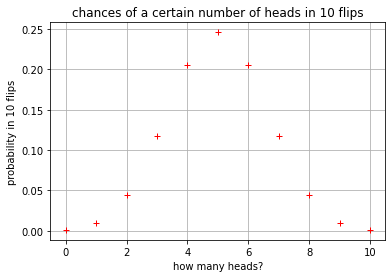

In [4]:
pl.plot(df.h,df.p,'r+')
pl.title("chances of a certain number of heads in 10 flips")
pl.xlabel("how many heads?")
pl.ylabel("probability in 10 flips")
pl.grid()

Now, it turns out the expectation value of the number of heads is just N.p (make sense?):

$$\mu = Np $$.

It's not as obvious, but nonetheless true that the variance is N.p.q. This means the standard deviation will be:

$$ \sigma = \sqrt{N p q}$$

If Np is fairly large it also turns out that the binomial distribution closely resembles a normal distribution. Let's try that!

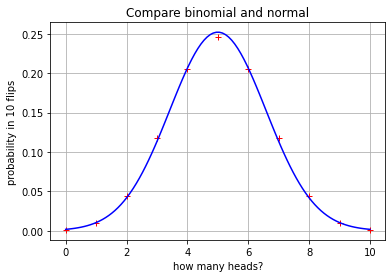

In [5]:
hrange=np.linspace(df.h.values[0],df.h.values[-1],100)
nd = norm.pdf(hrange,loc=N*p,scale=np.sqrt(N*p*q))
pl.plot(df.h,df.p,'r+')
pl.plot(hrange,nd,'b-')
pl.title("Compare binomial and normal")
pl.xlabel("how many heads?")
pl.ylabel("probability in 10 flips")
pl.grid()


What does this have to do with a Poisson distribution? 

* Suppose I have a very unfair coin so that it only get's heads 10% of the time (p=0.1). Suppose further I flip it once per second. Now I expect a 'head' once every 10s or so on the *average*, but it can come sooner, or much later, depending on luck. 
* What if I have a coin with p=0.01 but I flip it 10 times per second (maybe electronically). I'll get the *same* rate, but more time resolution (0.1 sec). 
* What if I have a coin with p=0.001, but I flip it 100 times per second? 

This is where the Poisson distribution comes in. Take the limit as N goes to infinity, but p goes to zero in such a way that N.p remains fixed. Then you have a Poisson distribution! The Poisson distribution as an expectation value $\lambda$ (like 0.1 heads per second).

$$P(k) = \frac {\lambda^k}{k!} e^{-\lambda}$$

Where $P(k)$ is the probability of $k$ events when the expection value is $\lambda$ events. In the Poisson distribution $q\approx1$ so $\sigma \approx \lambda$.

Example: Let's go back to the defect monitoring. What is the expected number of defects in one hour? Based on our expected time between defects this would be 10 minutes between defects, or 6 defects per hour. What's the chance of 5, or 4? Let's see:

In [6]:
from scipy.stats import poisson

results = []
N=15
lam=6

for ndefects in range(N+1):
    prob = poisson.pmf(ndefects, lam)
    results.append({'n':ndefects, 'p':prob})
    
df = pd.DataFrame(results)
df

,n,p
0,0,0.002479
1,1,0.014873
2,2,0.044618
3,3,0.089235
4,4,0.133853
5,5,0.160623
6,6,0.160623
7,7,0.137677
8,8,0.103258
9,9,0.068838


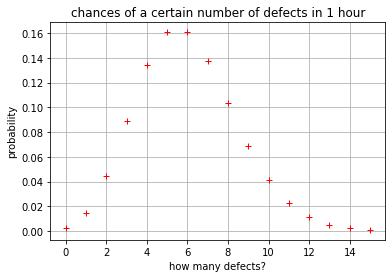

In [7]:
pl.plot(df.n,df.p,'r+')
pl.title("chances of a certain number of defects in 1 hour")
pl.xlabel("how many defects?")
pl.ylabel("probability")
pl.grid()

In [8]:
df.p.sum()

0.9994909017287822

Why don't the probabilities add exactly to one?

### Normal Approximation

As with the binomial distribution, the normal distribution can be used to approximate the poisson. It works best for large values of the expectation value. As you can see, the comparions here $\lambda=6$ is not wonderful. Experiment with it and determine which values of $\lambda$ give better agreement.

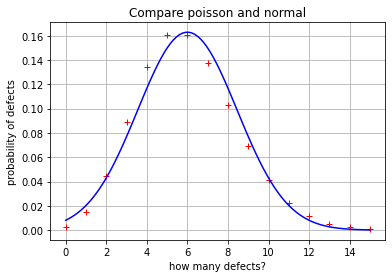

In [9]:
hrange=np.linspace(df.n.values[0],df.n.values[-1],100)
nd = norm.pdf(hrange,loc=lam,scale=np.sqrt(lam))
pl.plot(df.n,df.p,'r+')
pl.plot(hrange,nd,'b-')
pl.title("Compare poisson and normal")
pl.xlabel("how many defects?")
pl.ylabel("probability of defects")
pl.grid()


## Bayesian estimation

In the lab we can collect data from a poisson process (such as radioactive decay) and count the number of decay events per second over a long period of time. This week we collected some data during class. Let's use that data as an example of poisson distributed data.

In [10]:
y=pd.read_csv('poisson.csv').data.values
mu = y.mean()
ndata = len(y)

ndata, mu

(932, 20.990343347639485)

As you can see the *average* number of counts per scond was about 21. Is that a good estimator for the poisson parameter $\lambda$? Let's try another example of a Bayesian approch to see exactly how reliable that estimator is:

In [11]:
with pm.Model() as model:
    lam = pm.HalfCauchy("lam",50) # start with a fairly broad prior
    n = pm.Poisson("n", mu=lam, observed=y)
    trace = pm.sample(1000, return_inferencedata=True)
   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


,mean,sd,hdi_3%,hdi_97%
lam,20.991,0.148,20.704,21.249


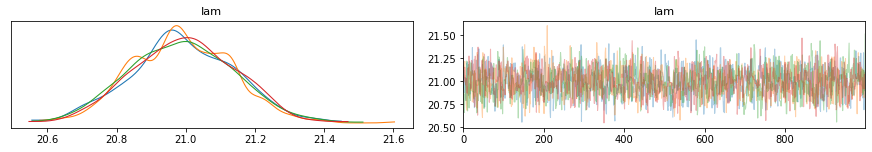

In [12]:
az.plot_trace(trace)
az.summary(trace,kind="stats")

So this confirms the simple mean as a reasonable estimator for the poisson parameter! Also, with the Bayesian analysis we get an estimate of the uncertainty in $\lambda$ for free! The 94% credibility region goes from ~20.7 to about ~21.3 or so.

There's also an easy way to sample from the posterior to compare to observation:

In [13]:
#
# You can use `sample_posterior_predictive` to compare the 
# model output using the posterior parameters to the observed
# data. Then use `plot_ppc` to visualize that comparison.
#

with model:
    ppc = pm.sample_posterior_predictive( 
        trace, var_names=["lam", "n"]
    )

Text(0.5, 1.0, 'Posterior predictive check')

/Users/steve/Development/instrumentation-projects/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


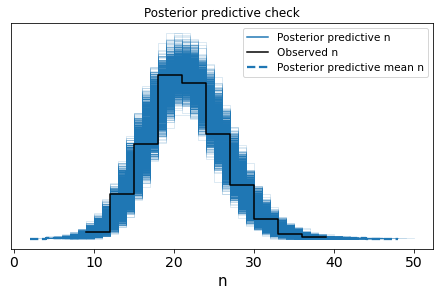

In [14]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))
pl.title("Posterior predictive check")

# Exercises

1) Experiment with the normal distribution and the poisson distribution. For what values of $\lambda$ does the agreement become acceptable?

2) Find some data from "real life" that you *suspect* may be poisson distributed. Use one or more of the approaches discussed here to make a case that the data actually *is* or *isn't* poisson distributed.

3) Develop a project that uses interrupts in some way. You can count events, measure time intervals, or something else (some sensors support interrupts for indicating a measurement is ready). Use Bayesian analysis again to make some inferences from your data.
